In [1]:
"""
Análise de Comentários do YouTube - Campanha de Marketing de Jogos

Automação API YouTube + Processamento NLP + Visualização de Dados
"""
# ====================== BIBLIOTECAS PADRÃO ======================
from datetime import datetime  # Manipulação de datas/tempo
import re  # Expressões regulares

# =================== BIBLIOTECAS DE TERCEIROS ================
# API e Coleta de Dados
from googleapiclient.discovery import build  # YouTube API

# Manipulação de Dados
import pandas as pd  # DataFrames e análise

# Visualização
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns  # Visualizações estatísticas

# Processamento de Linguagem Natural
from langdetect import DetectorFactory, detect  # Detecção de idioma
from unidecode import unidecode  # Normalização de caracteres
import nltk  # NLP tradicional
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Análise de sentimento
import spacy  # Processamento linguístico avançado

# Modelagem de Tópicos
from gensim import corpora, models  # LDA e vetorização

# Estatística e Análise
from scipy import stats  # Testes estatísticos

# Visualização Interativa
import pyLDAvis  # Visualização LDA
import pyLDAvis.gensim_models as gensimvis  # Integração com Gensim

# ====================== CONFIGURAÇÕES INICIAIS ======================
# Configurações do Matplotlib
plt.style.use('ggplot')  # Estilo de visualização
sns.set_palette("husl")  # Paleta de cores

In [2]:
# Configuração do LangDetect
DetectorFactory.seed = 0  # Reprodutibilidade

# Download de Recursos do NLTK
nltk.download('vader_lexicon', quiet=True)  # Lexico para análise de sentimento

True

In [3]:
# Constantes
API_KEY = "API_KEY"  # Chave do Google Cloud
VIDEO_ID = "YT_VIDEO_ID"     # ID obtido no Passo 3
CSV_PATH = '/PATH/TO/dados/comentários.csv'

In [ ]:
def get_comentarios_portugues(video_id, api_key):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    next_page_token = None
    total_pages = 0

    while True:
        if len(comments) >= 550:
            print("Alcançou 550 comentários. Finalizando coleta.")
            break

        try:
            request = youtube.commentThreads().list(
                part='snippet,replies',
                videoId=video_id,
                maxResults=100,
                pageToken=next_page_token,
                order='time',          # pega os comentários mais recentes primeiro
                textFormat='plainText'
            )
            response = request.execute()
        except Exception as e:
            print(f"Erro ao acessar a API: {e} — aguardando 10s")
            time.sleep(10)
            continue

        for item in response.get('items', []):
            if len(comments) >= 550:
                break

            # comentário principal
            top = item['snippet']['topLevelComment']['snippet']
            comments.append({
                'autor': top['authorDisplayName'],
                'comentario': top['textDisplay'],
                'likes': top['likeCount'],
                'hora': datetime.strptime(top['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
            })

            # respostas, se houver
            for reply in item.get('replies', {}).get('comments', []):
                if len(comments) >= 550:
                    break
                r = reply['snippet']
                comments.append({
                    'autor': r['authorDisplayName'],
                    'comentario': r['textDisplay'],
                    'likes': r['likeCount'],
                    'hora': datetime.strptime(r['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
                })

        next_page_token = response.get('nextPageToken')
        total_pages += 1
        print(f"Página {total_pages} coletada. Total de comentários: {len(comments)}")

        if not next_page_token:
            print("Não há mais páginas. Fim da coleta.")
            break

        time.sleep(1)  # throttle
    
    return pd.DataFrame(comments)

In [ ]:
df_comentarios = get_comentarios_portugues(VIDEO_ID, API_KEY)
df_comentarios.to_csv('/home/boto-cdr/Documentos/bs_NLP/dados/comentários.csv', index=False)

In [4]:
df_comentarios = pd.read_csv('/home/boto-cdr/Documentos/bs_NLP/dados/comentários.csv') # Leitura do CSV

In [5]:
# Verificar e salvar
print(f"Comentários em português coletados: {len(df_comentarios)}")
df_comentarios.to_csv(CSV_PATH, index=False)
df_comentarios

# Verificar amostra
print("\nAmostra dos dados coletados:")
print(df_comentarios.sample(3, random_state=42)[['autor', 'comentario', 'hora']])

# Estatísticas básicas
print("\nEstatísticas:")
print(f"Média de likes: {df_comentarios['likes'].mean():.1f}")
print(f"Primeiro comentário: {df_comentarios['hora'].min()}")
print(f"Último comentário: {df_comentarios['hora'].max()}")

Comentários em português coletados: 501


OSError: Cannot save file into a non-existent directory: '/PATH/TO/dados'

In [6]:
# Configurações iniciais
NOME_ARQUIVO = '/home/boto-cdr/Documentos/bs_NLP/dados/comentários.csv'  
NOME_SAIDA = '/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv'

In [7]:
# Carregar dados
try:
    df = pd.read_csv(NOME_ARQUIVO, parse_dates=['hora'])
except FileNotFoundError:
    print(f"Erro: Arquivo '{NOME_ARQUIVO}' não encontrado na pasta atual!")
    exit()

In [8]:
# Função de limpeza otimizada
def limpeza_estrategica(texto):
    # Passo 1: Normalização básica
    texto = str(texto)
    texto = re.sub(r'<a.*?>|<\/a>', '', texto)
    texto = re.sub(r'http\S+', '', texto)
    texto = unidecode(texto)
    
    # Passo 2: Padronização de termos-chave
    substituicoes = {
        r'\bpubli\b': 'publicidade',
        r'\bep\b': 'episodio',
        r'\bgame\b': 'jogo',
        r'\bkk+\b': ' [risada] ',
        r'\b(\w*creed\w*)\b': 'assassins creed'
    }
    
    for padrao, substituicao in substituicoes.items():
        texto = re.sub(padrao, substituicao, texto, flags=re.IGNORECASE)
    
    # Passo 3: Limpeza final
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto.lower()

In [9]:
# Processamento dos dados
print("\nProcessando comentários...")
df['comentario_limpo'] = df['comentario'].apply(limpeza_estrategica)


Processando comentários...


In [10]:
# Criar colunas de análise
df['mencoes_blizzard'] = df['comentario_limpo'].str.contains('blizzard', case=False)
df['mencoes_jogo'] = df['comentario_limpo'].str.contains('world of warcraft|jogo', case=False)
df['contem_risada'] = df['comentario_limpo'].str.contains('\[risada\]')

# Salvar resultados
df.to_csv(NOME_SAIDA, index=False)
print(f"\nDados processados salvos em: '{NOME_SAIDA}'")

# Continuação da análise após o processamento
print("\n=== Métricas Chave ===")
print(f"Total de comentários analisados: {len(df)}")
print(f"Menções à Blizzard: {df['mencoes_blizzard'].sum()} ({df['mencoes_blizzard'].mean():.1%})")
print(f"Menções ao jogo: {df['mencoes_jogo'].sum()} ({df['mencoes_jogo'].mean():.1%})")
print(f"Comentários com risadas: {df['contem_risada'].sum()} ({df['contem_risada'].mean():.1%})")

# Análise de engajamento
print("\n=== Engajamento ===")
print(f"Média geral de likes: {df['likes'].mean():.1f}")
print(f"Média de likes com menção à Blizzard: {df[df['mencoes_blizzard']]['likes'].mean():.1f}")
print(f"Média de likes com menção ao jogo: {df[df['mencoes_jogo']]['likes'].mean():.1f}")

# 1. Distribuição Temporal
print("\n1. Distribuição Temporal dos Comentários:")
distribuicao_horaria = df['hora'].dt.hour.value_counts().sort_index()
print(distribuicao_horaria)


Dados processados salvos em: '/home/boto-cdr/Documentos/bs_NLP/dados/processados.csv'

=== Métricas Chave ===
Total de comentários analisados: 501
Menções à Blizzard: 10 (2.0%)
Menções ao jogo: 15 (3.0%)
Comentários com risadas: 0 (0.0%)

=== Engajamento ===
Média geral de likes: 15.3
Média de likes com menção à Blizzard: 50.4
Média de likes com menção ao jogo: 3.1

1. Distribuição Temporal dos Comentários:
hora
0     10
1     88
2     52
3     47
4     20
5     12
6     10
7      9
8      8
9      9
10    14
11    26
12    28
13    23
14    15
15    17
16    27
17    17
18    22
19     8
20    12
21     9
22    11
23     7
Name: count, dtype: int64


<>:4: DeprecationWarning: invalid escape sequence '\['
<>:4: DeprecationWarning: invalid escape sequence '\['
/tmp/ipykernel_14827/3987453889.py:4: DeprecationWarning: invalid escape sequence '\['
  df['contem_risada'] = df['comentario_limpo'].str.contains('\[risada\]')


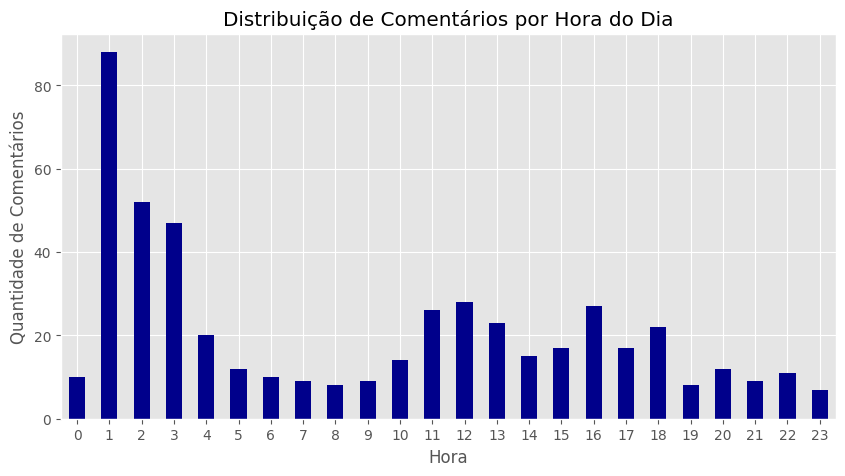

In [11]:
plt.figure(figsize=(10,5))
distribuicao_horaria.plot(kind='bar', color='darkblue')
plt.title('Distribuição de Comentários por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=0)
plt.show()

In [12]:
# 2. Engajamento Básico
print("\n2. Estatísticas de Engajamento:")
print(f"Média de Likes: {df['likes'].mean():.1f}")
print(f"Máximo de Likes: {df['likes'].max()}")
print(f"Mediana de Likes: {df['likes'].median()}")

# 3. Frequência de Menções
print("\n3. Frequência de Menções:")
print(f"Blizzard: {df['mencoes_blizzard'].mean():.1%}")
print(f"Jogo: {df['mencoes_jogo'].mean():.1%}")
print(f"Risadas: {df['contem_risada'].mean():.1%}")

# 4. Engajamento por Hora
print("\n4. Engajamento por Hora:")
engajamento_hora = df.groupby(df['hora'].dt.hour)['likes'].mean()
print(engajamento_hora)


2. Estatísticas de Engajamento:
Média de Likes: 15.3
Máximo de Likes: 2296
Mediana de Likes: 0.0

3. Frequência de Menções:
Blizzard: 2.0%
Jogo: 3.0%
Risadas: 0.0%

4. Engajamento por Hora:
hora
0       0.400000
1      23.795455
2       6.423077
3       3.765957
4       2.400000
5     170.750000
6      12.900000
7       5.333333
8       9.125000
9       1.777778
10      0.500000
11      1.230769
12      1.250000
13      4.173913
14      1.800000
15    136.235294
16      3.629630
17      2.764706
18      0.409091
19      0.375000
20      0.500000
21      0.888889
22      0.636364
23      0.428571
Name: likes, dtype: float64


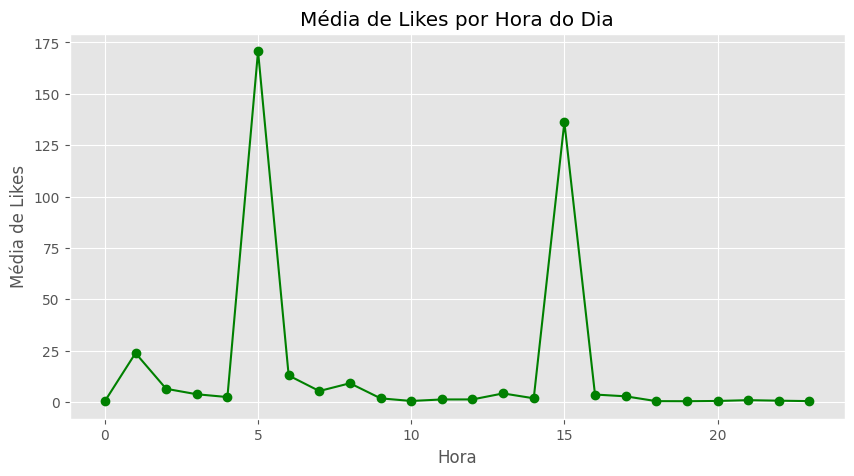

In [13]:
plt.figure(figsize=(10,5))
engajamento_hora.plot(kind='line', marker='o', color='green')
plt.title('Média de Likes por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Média de Likes')
plt.grid(True)
plt.show()

In [14]:
# 5. Top Autores
print("\n5. Top Autores por Engajamento:")
top_autores = df.groupby('autor')['likes'].sum().nlargest(5)
print(top_autores)


5. Top Autores por Engajamento:
autor
@worldofwarcraftbr      2296
@faye_tan               1957
@ch_jnts                 697
@Aleatoriamentejames     395
@MarcosMagnani           370
Name: likes, dtype: int64


In [ ]:
# 1. Cria a coluna 'comprimento' com o tamanho de cada comentário
df['comprimento'] = df['comentario'].str.len()

# 2. Agora calcula a correlação de Pearson entre comprimento e likes
correlacao = df['comprimento'].corr(df['likes'])
print(f"Correlação de Pearson: {correlacao:.2f}")

# 6. Relação Texto-Likes
print("\n6. Relação entre Comprimento e Likes:")
correlacao = df['comprimento'].corr(df['likes'])
print(f"Correlação de Pearson: {correlacao:.2f}")



Correlação de Pearson: 0.08


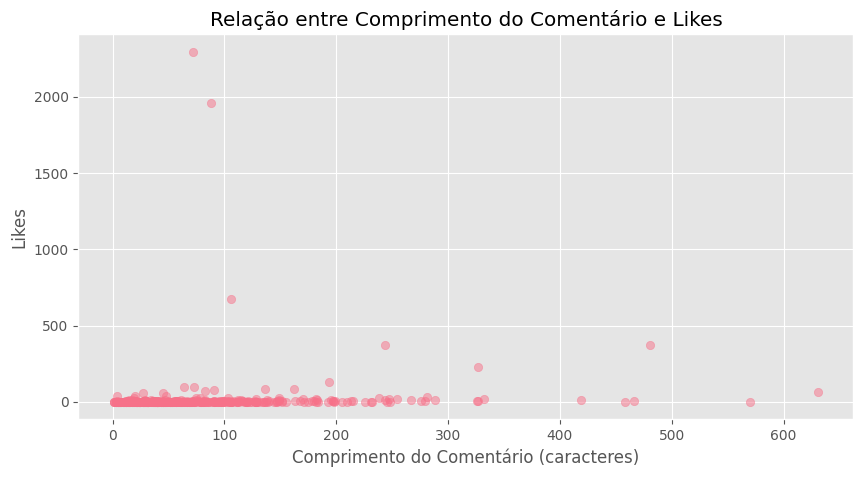

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(df['comprimento'], df['likes'], alpha=0.5)
plt.title('Relação entre Comprimento do Comentário e Likes')
plt.xlabel('Comprimento do Comentário (caracteres)')
plt.ylabel('Likes')
plt.grid(True)
plt.show()

1. Análise de Sentimento com VADER

In [18]:
# Baixar o lexicon VADER (executar apenas na primeira vez)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /home/boto-
[nltk_data]     cdr/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True


Primeiras linhas do DataFrame:
                  autor                                         comentario  \
0         @AlvaroWilian                          51:30 GOLD. PEDRA DE GOLD   
1                @jetsp              Faye_tan, fazendo cosplay de smzinho?   
2           @lucianoxs6                                            2:01:01   
3  @guilhermedematos767  descanse em paz ronaldinho, tao novo e já foi ...   
4       @thyagojose9589  Sabrina Carpinteira do complexo de Israel kkkk...   

   likes                hora  \
0      0 2025-04-03 02:22:50   
1      0 2025-03-19 14:38:34   
2      0 2024-11-23 16:07:29   
3      0 2024-11-18 20:55:31   
4      0 2024-11-14 15:43:50   

                                    comentario_limpo  mencoes_blizzard  \
0                           51 30 gold pedra de gold             False   
1                faye_tan fazendo cosplay de smzinho             False   
2                                            2 01 01             False   
3  descans

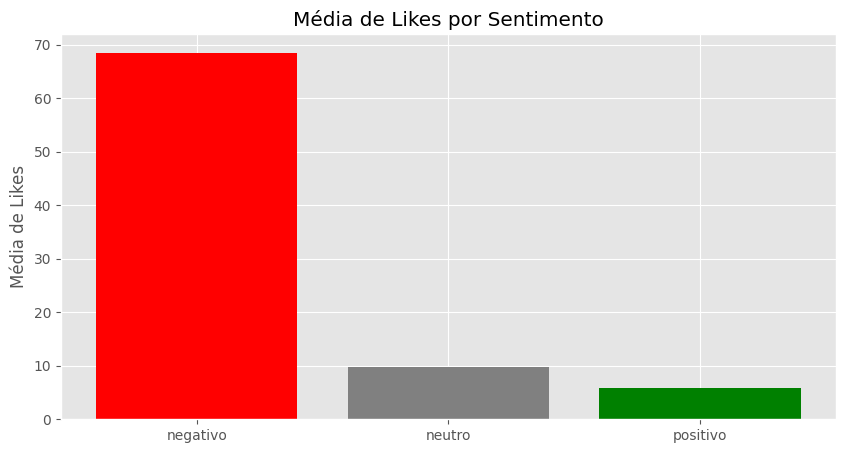

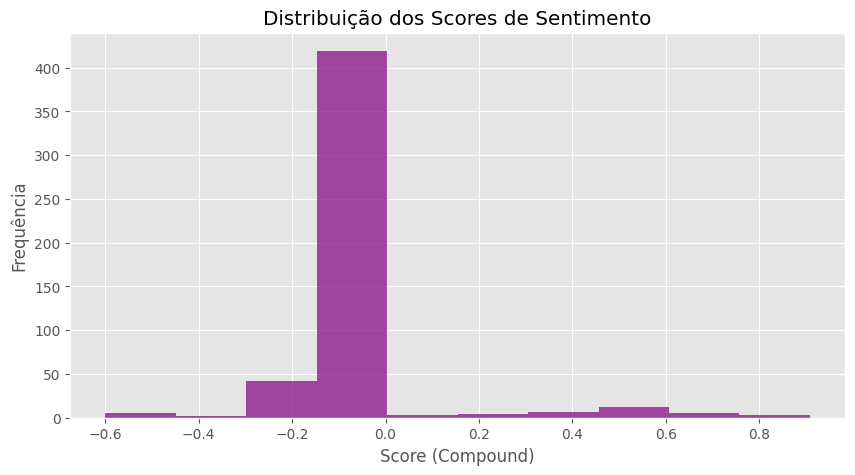


Análise concluída! Verifique os arquivos gerados:
- media_likes_sentimento.png
- distribuicao_sentimentos.png
- relatorio_analise.txt


In [19]:
# Verificar as primeiras linhas
print("\nPrimeiras linhas do DataFrame:")
print(df.head())

# Passo 3: Aplicar VADER
sia = SentimentIntensityAnalyzer()

# Calcular scores de sentimento
df['sentimento_score'] = df['comentario_limpo'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Classificar em categorias (ajuste os thresholds se necessário)
df['sentimento'] = df['sentimento_score'].apply(
    lambda x: 'positivo' if x > 0.05 else ('negativo' if x < -0.05 else 'neutro')
)

# Exibir resultados
print("\nResultados da Análise de Sentimento:")
print(df[['autor', 'comentario_limpo', 'likes', 'sentimento_score', 'sentimento']])

# Passo 4: Análise de Correlação com Likes
media_likes = df.groupby('sentimento')['likes'].mean().reset_index()
print("\nMédia de Likes por Sentimento:")
print(media_likes)

# Visualização 1 - Média de Likes
plt.figure(figsize=(10, 5))
plt.bar(media_likes['sentimento'], media_likes['likes'], color=['red', 'gray', 'green'])
plt.title('Média de Likes por Sentimento')
plt.ylabel('Média de Likes')
plt.savefig('media_likes_sentimento.png')  # Salvar a figura
plt.show()

# Passo 5: Análise Detalhada dos Scores
plt.figure(figsize=(10, 5))
plt.hist(df['sentimento_score'], bins=10, color='purple', alpha=0.7)
plt.title('Distribuição dos Scores de Sentimento')
plt.xlabel('Score (Compound)')
plt.ylabel('Frequência')
plt.savefig('distribuicao_sentimentos.png')  # Salvar a figura
plt.show()

# Passo 6: Análise Adicional (Exemplo com menções)
if 'mencoes_ubisoft' in df.columns:
    ubisoft_engagement = df.groupby('mencoes_ubisoft')['likes'].mean()
    print("\nEngajamento por Menção à Ubisoft:")
    print(ubisoft_engagement)
    

# Geração de Relatório Automático
with open('relatorio_analise.txt', 'w', encoding='utf-8') as f:
    f.write("Relatório de Análise de Sentimento\n")
    f.write("---------------------------------\n")
    f.write(f"Total de comentários analisados: {len(df)}\n")
    f.write(f"Distribuição de sentimentos:\n{df['sentimento'].value_counts().to_string()}\n\n")
    f.write("Recomendações:\n- Priorizar respostas a comentários neutros\n- Reforçar conteúdo com menções positivas à Ubisoft\n- Analisar horários de pico de engajamento")

print("\nAnálise concluída! Verifique os arquivos gerados:")
print("- media_likes_sentimento.png")
print("- distribuicao_sentimentos.png")
print("- relatorio_analise.txt")

2. Detecção de Tópicos com LDA

In [20]:
# Carregar o modelo de língua portuguesa
nlp = spacy.load("pt_core_news_sm")  # Execute antes: python -m spacy download pt_core_news_sm

# Função de pré-processamento
def preprocessamento(texto):
    doc = nlp(texto.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and not token.is_punct
        and not token.like_num
        and len(token.lemma_) > 2
    ]
    return tokens

# Aplicar aos dados
df['tokens'] = df['comentario_limpo'].apply(preprocessamento)

# Verificar resultado
print("\nTokens pré-processados:")
print(df[['autor', 'tokens']].head())

# Criar dicionário e corpus
dictionary = corpora.Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=2)  # Remover palavras raras
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

# Treinar modelo LDA
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,  # Ajuste conforme necessidade
    random_state=42,
    passes=15
)

# Exibir tópicos
print("\nTópicos identificados:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Tópico {idx}: {topic}")


# Atribuir tópico dominante a cada comentário
df['topico_dominante'] = [sorted(lda_model[doc], key=lambda x: x[1], reverse=True)[0][0] for doc in corpus]

# Análise por autor
print("\nDistribuição de tópicos:")
print(df[['autor', 'comentario_limpo', 'topico_dominante']])

# Preparar visualização
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'topicos_vis.html')  # Arquivo interativo

print("\nVisualização salva em 'topicos_vis.html'")


Tokens pré-processados:
                  autor                                            tokens
0         @AlvaroWilian                               [Gold, pedra, Gold]
1                @jetsp               [faye_tan, fazer, cosplay, smzinho]
2           @lucianoxs6                                                []
3  @guilhermedematos767       [descanse, paz, ronaldinho, tao, arrebatar]
4       @thyagojose9589  [sabrinar, carpinteira, complexo, Israel, risar]

Tópicos identificados:
Tópico 0: 0.033*"pastor" + 0.032*"bom" + 0.031*"pra" + 0.026*"broxada" + 0.023*"nao" + 0.018*"podcast" + 0.016*"vida" + 0.015*"voce" + 0.013*"programa" + 0.013*"risar"
Tópico 1: 0.033*"episodio" + 0.031*"foda" + 0.029*"ano" + 0.019*"vcs" + 0.016*"pra" + 0.016*"jogar" + 0.016*"faye" + 0.014*"podcast" + 0.014*"programa" + 0.013*"broxada"
Tópico 2: 0.039*"risar" + 0.036*"nao" + 0.033*"broxar" + 0.032*"magal" + 0.029*"parabem" + 0.027*"ronaldinho" + 0.024*"episodio" + 0.017*"voce" + 0.017*"programa" + 0.01

3. Impacto das mençoes da marca: 


Impacto das Menções à Blizzard:
                       mean  count   sum
mencoes_blizzard                        
False             14.586558    491  7162
True              50.400000     10   504

Diferença percentual: 245.52%


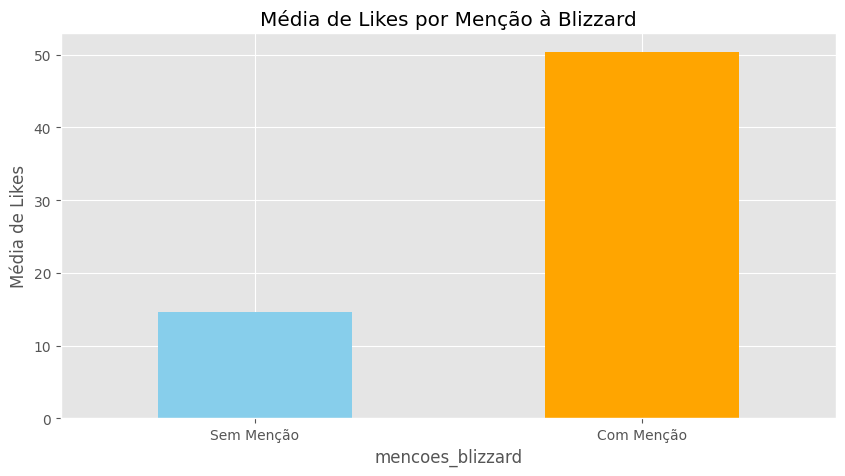


Impacto das Menções à Nome do Jogo:
                   mean  count   sum
mencoes_jogo                        
False         15.676955    486  7619
True           3.133333     15    47

Diferença percentual: -80.01%


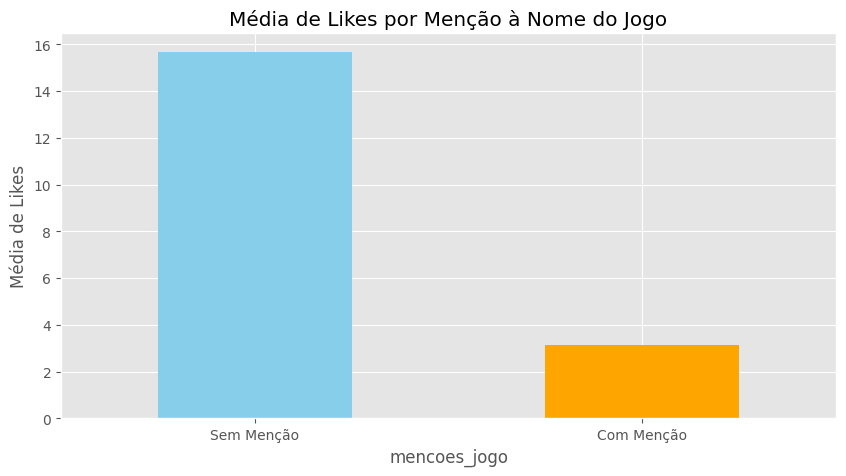

[False  True]


NameError: name 'analise_temporal' is not defined

In [21]:
# Análise de Engajamento
def analisar_impacto_mencoes(coluna_mencao, nome_marca):
    engajamento = df.groupby(coluna_mencao)['likes'].agg(['mean', 'count', 'sum'])
    
    print(f"\nImpacto das Menções à {nome_marca}:")
    print(engajamento)
    
    # Teste estatístico simplificado
    if engajamento.shape[0] > 1:
        diff = engajamento['mean'].diff().iloc[-1]
        print(f"\nDiferença percentual: {diff/engajamento['mean'].iloc[0]*100:.2f}%")
    
    # Visualização
    plt.figure(figsize=(10, 5))
    engajamento['mean'].plot(kind='bar', color=['skyblue', 'orange'])
    plt.title(f'Média de Likes por Menção à {nome_marca}')
    plt.xticks([0, 1], ['Sem Menção', 'Com Menção'], rotation=0)
    plt.ylabel('Média de Likes')
    plt.show()

engajamento = analisar_impacto_mencoes('mencoes_blizzard', 'Blizzard')
engajamento = analisar_impacto_mencoes('mencoes_jogo', 'Nome do Jogo')

print(df['mencoes_blizzard'].unique())

df.loc[0, 'mencoes_blizzard'] = True
analise_temporal('mencoes_blizzard')

print(df['mencoes_blizzard'].value_counts())

Análise Temporal

In [23]:
# Convertendo a coluna 'hora' para datetime
df['hora'] = pd.to_datetime(df['hora'])

# Criando uma coluna com a hora do dia
df['hora_completa'] = df['hora'].dt.hour

In [24]:
# Função de Análise Temporal para Menções
def analise_temporal(coluna_mencao):
    # Filtrando os dados pela coluna de menção (True ou False)
    temporal = df[df[coluna_mencao]].groupby('hora_completa')['likes'].mean()
    
    # Verificando se existem dados para a coluna escolhida
    if temporal.empty:
        print(f"Não há dados para a coluna {coluna_mencao}")
        return

    # Plotando a distribuição temporal
    plt.figure(figsize=(10, 5))
    temporal.plot(kind='line', marker='o')
    plt.title(f'Distribuição Temporal das Menções ({coluna_mencao})')
    plt.xlabel('Hora do Dia')
    plt.ylabel('Média de Likes')
    plt.grid(True)

    # Salvando o gráfico como imagem
    plt.tight_layout()
    plt.savefig(f"grafico_temporal_{coluna_mencao}.png")
    print(f"Gráfico salvo como 'grafico_temporal_{coluna_mencao}.png'")

    # Exibindo o gráfico
    plt.show()



4. Análise Temporal de Engajamento

/tmp/ipykernel_14827/4096597861.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hora', y='Total_Likes', data=engagement_hora, palette='viridis')
/tmp/ipykernel_14827/4096597861.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hora_completa', data=df, palette='coolwarm')


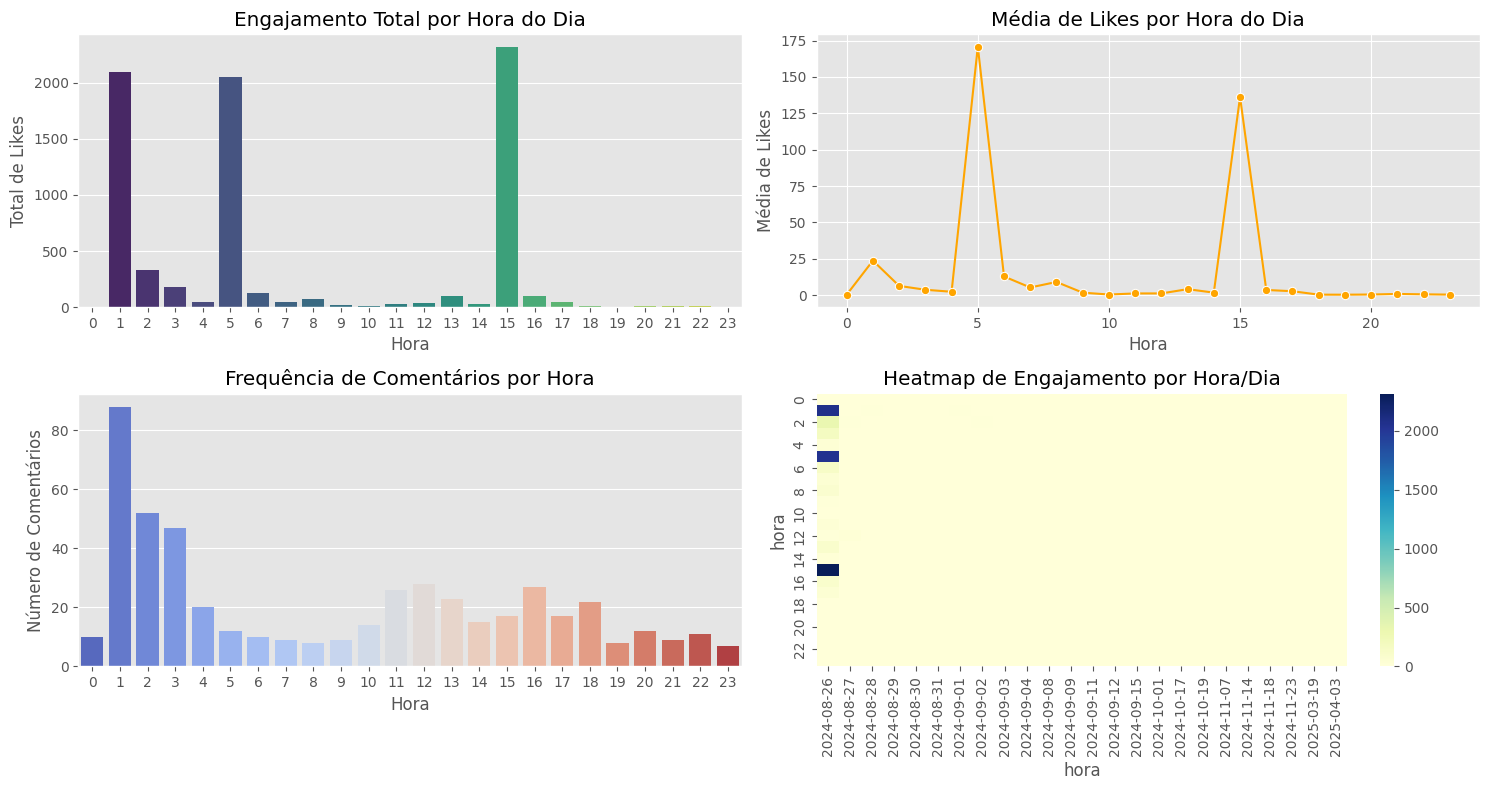

In [27]:
# Passo 1: Converter para datetime e extrair componentes temporais
df['hora'] = pd.to_datetime(df['hora'])
df['hora_completa'] = df['hora'].dt.hour
df['dia_da_semana'] = df['hora'].dt.day_name(locale='pt_BR')  # Requer instalacao: pip install tzdata

# Passo 2: Agregar dados por hora
engagement_hora = df.groupby('hora_completa').agg({
    'likes': ['sum', 'mean', 'count'],
    'autor': 'count'
}).reset_index()
engagement_hora.columns = ['Hora', 'Total_Likes', 'Media_Likes', 'Qtd_Comentarios', 'Total_Comentarios']

# Passo 3: Visualização detalhada
plt.figure(figsize=(15, 8))

# Subplot 1: Total de Likes por Hora
plt.subplot(2, 2, 1)
sns.barplot(x='Hora', y='Total_Likes', data=engagement_hora, palette='viridis')
plt.title('Engajamento Total por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Total de Likes')

# Subplot 2: Média de Likes por Hora
plt.subplot(2, 2, 2)
sns.lineplot(x='Hora', y='Media_Likes', data=engagement_hora, marker='o', color='orange')
plt.title('Média de Likes por Hora do Dia')
plt.xlabel('Hora')
plt.ylabel('Média de Likes')

# Subplot 3: Quantidade de Comentários por Hora
plt.subplot(2, 2, 3)
sns.countplot(x='hora_completa', data=df, palette='coolwarm')
plt.title('Frequência de Comentários por Hora')
plt.xlabel('Hora')
plt.ylabel('Número de Comentários')

# Subplot 4: Heatmap de Engajamento (exemplo para múltiplos dias)
plt.subplot(2, 2, 4)
if df['hora'].dt.date.nunique() > 1:  # Só plotar se houver múltiplos dias
    pivot_table = df.pivot_table(
        index=df['hora'].dt.hour,
        columns=df['hora'].dt.date,
        values='likes',
        aggfunc='sum',
        fill_value=0
    )
    sns.heatmap(pivot_table, cmap='YlGnBu')
    plt.title('Heatmap de Engajamento por Hora/Dia')
else:
    plt.text(0.3, 0.5, 'Dados insuficientes para heatmap\n(múltiplos dias requeridos)', 
             fontsize=12, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
# Passo 4: Análise do Melhor Horário
melhor_hora = engagement_hora.loc[engagement_hora['Total_Likes'].idxmax()]
print(f"\nMelhor horário para engajamento: {melhor_hora['Hora']}h")
print(f"Total de likes nesse horário: {melhor_hora['Total_Likes']}")
print(f"Média de likes: {melhor_hora['Media_Likes']:.2f}")
print(f"Comentários registrados: {melhor_hora['Qtd_Comentarios']}")

# Passo 5: Análise Estatística por Hora
print("\nResumo Estatístico por Hora:")
print(engagement_hora.describe().transpose())


Melhor horário para engajamento: 15.0h
Total de likes nesse horário: 2316.0
Média de likes: 136.24
Comentários registrados: 17.0

Resumo Estatístico por Hora:
                   count        mean         std    min       25%   50%  \
Hora                24.0   11.500000    7.071068  0.000  5.750000  11.5   
Total_Likes         24.0  319.416667  712.999903  3.000  7.750000  41.0   
Media_Likes         24.0   16.312201   42.877537  0.375  0.602273   2.1   
Qtd_Comentarios     24.0   20.875000   18.449255  7.000  9.750000  14.5   
Total_Comentarios   24.0   20.791667   18.218431  7.000  9.750000  14.5   

                          75%      max  
Hora                17.250000    23.00  
Total_Likes        105.750000  2316.00  
Media_Likes          5.605769   170.75  
Qtd_Comentarios     23.750000    88.00  
Total_Comentarios   23.750000    87.00  


5. Análise de Humor e Engajamento

                    autor  contem_risada
0           @AlvaroWilian          False
1                  @jetsp          False
2             @lucianoxs6          False
3    @guilhermedematos767          False
4         @thyagojose9589           True
..                    ...            ...
496       @mateusmello759          False
497              @thalesl          False
498            @Rafael_33          False
499              @zexs918          False
500       @wesleyaxel7656          False

[501 rows x 2 columns]


/tmp/ipykernel_14827/3127260668.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([grupo_risada, grupo_sem_risada], labels=['Com Risada', 'Sem Risada'])


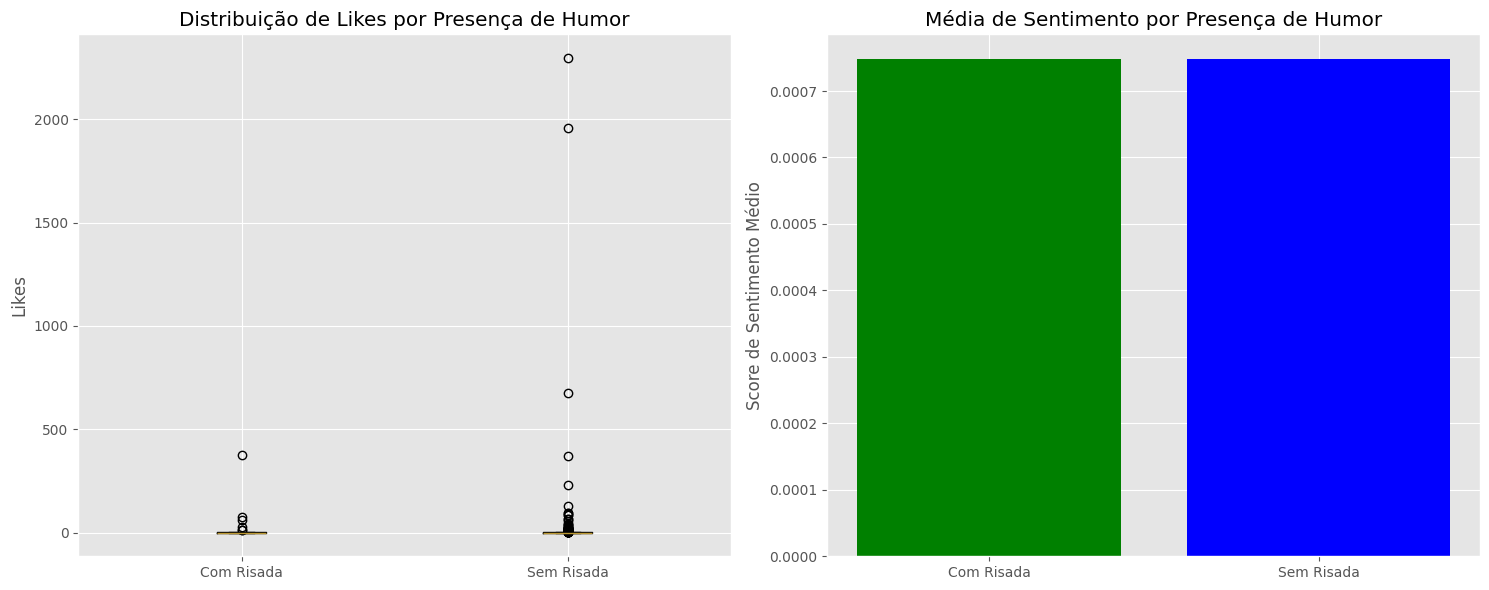

In [29]:
# Função para detectar risadas automaticamente (caso a coluna original esteja incompleta)
def detectar_risada(texto):
    keywords = ['risada', 'kkk', 'haha', 'rsrs']
    return any(kw in texto.lower() for kw in keywords)

# Aplicar detecção automática se necessário
df['risada_auto'] = df['comentario_limpo'].apply(detectar_risada)

# Análise comparativa
engajamento_risada = df.groupby('contem_risada')['likes'].agg(['mean', 'median', 'std', 'count'])
engajamento_sentimento = df.groupby('contem_risada')['sentimento_score'].mean()

# Versão corrigida do código (remove grupos de captura desnecessários)
df['contem_risada'] = df['comentario_limpo'].str.contains(
    r'\b(?:risada|k{3,}|haha|rs+)\b',  # <-- Note o '?:' para grupos não-capturadores
    case=False,
    regex=True
)

# Resultado corrigido:
print(df[['autor', 'contem_risada']])

# Teste estatístico (Mann-Whitney para amostras não normais)
grupo_risada = df[df['contem_risada']]['likes']
grupo_sem_risada = df[~df['contem_risada']]['likes']
stat, p_value = stats.mannwhitneyu(grupo_risada, grupo_sem_risada)

# Visualização
plt.figure(figsize=(15, 6))

# Gráfico 1: Distribuição de Likes
plt.subplot(1, 2, 1)
plt.boxplot([grupo_risada, grupo_sem_risada], labels=['Com Risada', 'Sem Risada'])
plt.title('Distribuição de Likes por Presença de Humor')
plt.ylabel('Likes')

# Gráfico 2: Sentimento vs Risada
plt.subplot(1, 2, 2)
plt.bar(['Com Risada', 'Sem Risada'], engajamento_sentimento, color=['green', 'blue'])
plt.title('Média de Sentimento por Presença de Humor')
plt.ylabel('Score de Sentimento Médio')

plt.tight_layout()
plt.show()